# Ensemble of two models
Used 2 notebooks:
* https://www.kaggle.com/code/jvthunder/lstm-baseline-for-starters-sign-language (with my own train  - LB = 0.6);
* https://www.kaggle.com/code/roberthatch/gislr-lb-0-63-on-the-shoulders (LB = 0.63)


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, optimizers

### Load models

In [2]:
asl_model = keras.models.load_model('/kaggle/input/gislr-tf-on-the-shoulders-s/models/asl_model')
ltsm_model = keras.models.load_model('/kaggle/input/googlecode/lstm5.h5')

In [3]:
asl_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 5796)]            0         
                                                                 
 dense_3 (Dense)             (None, 1024)              5936128   
                                                                 
 batch_normalization_2 (Batc  (None, 1024)             4096      
 hNormalization)                                                 
                                                                 
 activation_2 (Activation)   (None, 1024)              0         
                                                                 
 dropout_2 (Dropout)         (None, 1024)              0         
                                                                 
 dense_4 (Dense)             (None, 512)               524800    
                                                           

In [4]:
ltsm_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, 264)]       0         
                                                                 
 dense (Dense)               (None, None, 512)         135680    
                                                                 
 layer_normalization (LayerN  (None, None, 512)        1024      
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, None, 512)         0         
                                                                 
 dense_1 (Dense)             (None, None, 256)         131328    
                                                                 
 layer_normalization_1 (Laye  (None, None, 256)        512       
 rNormalization)                                             

### Params and utils

In [5]:
ROWS_PER_FRAME = 543
LANDMARK_IDX = [0,9,11,13,14,17,117,118,119,199,346,347,348] + list(range(468,543))

In [6]:
DROP_Z = False

NUM_FRAMES = 15
SEGMENTS = 3

LEFT_HAND_OFFSET = 468
POSE_OFFSET = LEFT_HAND_OFFSET+21
RIGHT_HAND_OFFSET = POSE_OFFSET+33

## average over the entire face, and the entire 'pose'
averaging_sets = [[0, 468], [POSE_OFFSET, 33]]

lip_landmarks = [61, 185, 40, 39, 37,  0, 267, 269, 270, 409,
                 291,146, 91,181, 84, 17, 314, 405, 321, 375, 
                 78, 191, 80, 81, 82, 13, 312, 311, 310, 415, 
                 95, 88, 178, 87, 14,317, 402, 318, 324, 308]
left_hand_landmarks = list(range(LEFT_HAND_OFFSET, LEFT_HAND_OFFSET+21))
right_hand_landmarks = list(range(RIGHT_HAND_OFFSET, RIGHT_HAND_OFFSET+21))

point_landmarks = [item for sublist in [lip_landmarks, left_hand_landmarks, right_hand_landmarks] for item in sublist]

LANDMARKS = len(point_landmarks) + len(averaging_sets)
print(LANDMARKS)
if DROP_Z:
    INPUT_SHAPE = (NUM_FRAMES,LANDMARKS*2)
else:
    INPUT_SHAPE = (NUM_FRAMES,LANDMARKS*3)

FLAT_INPUT_SHAPE = (INPUT_SHAPE[0] + 2 * (SEGMENTS + 1)) * INPUT_SHAPE[1]

84


In [7]:
def tf_nan_mean(x, axis=0):
    return tf.reduce_sum(tf.where(tf.math.is_nan(x), tf.zeros_like(x), x), axis=axis) / tf.reduce_sum(tf.where(tf.math.is_nan(x), tf.zeros_like(x), tf.ones_like(x)), axis=axis)

def tf_nan_std(x, axis=0):
    d = x - tf_nan_mean(x, axis=axis)
    return tf.math.sqrt(tf_nan_mean(d * d, axis=axis))

def flatten_means_and_stds(x, axis=0):
    # Get means and stds
    x_mean = tf_nan_mean(x, axis=0)
    x_std  = tf_nan_std(x,  axis=0)

    x_out = tf.concat([x_mean, x_std], axis=0)
    x_out = tf.reshape(x_out, (1, INPUT_SHAPE[1]*2))
    x_out = tf.where(tf.math.is_finite(x_out), x_out, tf.zeros_like(x_out))
    return x_out

class FeatureGen(tf.keras.layers.Layer):
    def __init__(self):
        super(FeatureGen, self).__init__()
    
    def call(self, x_in):
        if DROP_Z:
            x_in = x_in[:, :, 0:2]
        x_list = [tf.expand_dims(tf_nan_mean(x_in[:, av_set[0]:av_set[0]+av_set[1], :], axis=1), axis=1) for av_set in averaging_sets]
        x_list.append(tf.gather(x_in, point_landmarks, axis=1))
        x = tf.concat(x_list, 1)

        x_padded = x
        for i in range(SEGMENTS):
            p0 = tf.where( ((tf.shape(x_padded)[0] % SEGMENTS) > 0) & ((i % 2) != 0) , 1, 0)
            p1 = tf.where( ((tf.shape(x_padded)[0] % SEGMENTS) > 0) & ((i % 2) == 0) , 1, 0)
            paddings = [[p0, p1], [0, 0], [0, 0]]
            x_padded = tf.pad(x_padded, paddings, mode="SYMMETRIC")
        x_list = tf.split(x_padded, SEGMENTS)
        x_list = [flatten_means_and_stds(_x, axis=0) for _x in x_list]

        x_list.append(flatten_means_and_stds(x, axis=0))
        
        ## Resize only dimension 0. Resize can't handle nan, so replace nan with that dimension's avg value to reduce impact.
        x = tf.image.resize(tf.where(tf.math.is_finite(x), x, tf_nan_mean(x, axis=0)), [NUM_FRAMES, LANDMARKS])
        x = tf.reshape(x, (1, INPUT_SHAPE[0]*INPUT_SHAPE[1]))
        x = tf.where(tf.math.is_nan(x), tf.zeros_like(x), x)
        x_list.append(x)
        x = tf.concat(x_list, axis=1)
        return x

### Make ensemble 

In [8]:
def get_inference_model(model,asl_model):
    inputs = tf.keras.Input(shape=(ROWS_PER_FRAME,3), name="inputs")
    
    # drop most of the face mesh
    x = tf.gather(inputs, LANDMARK_IDX, axis=1)

    # fill nan
    x = tf.where(tf.math.is_nan(x), tf.zeros_like(x), x)

    # flatten landmark xyz coordinates ()
    x = tf.concat([x[...,i] for i in range(3)], -1)

    x = tf.expand_dims(x,0)
    
    # call trained model
    out = model(x)
    
    #model 2
    prep_inputs = FeatureGen()
#     x2 = prep_inputs(tf.cast(inputs, dtype=tf.float32))
#     out2 = asl_model(x2)
    x2 = prep_inputs(tf.cast(inputs, dtype=tf.float32))
    out2 = asl_model(x2)
    
    #out3 = tf.keras.layers.Average()([out,out2])
    out3 = tf.keras.layers.Add()([0.45*out,0.55*out2])
    
    # explicitly name the final (identity) layer for the submission format
    out = layers.Activation("linear", name="outputs")(out3)
    
    inference_model = tf.keras.Model(inputs=inputs, outputs=out)
    inference_model.compile(loss="sparse_categorical_crossentropy",
                            metrics="accuracy")
    return inference_model

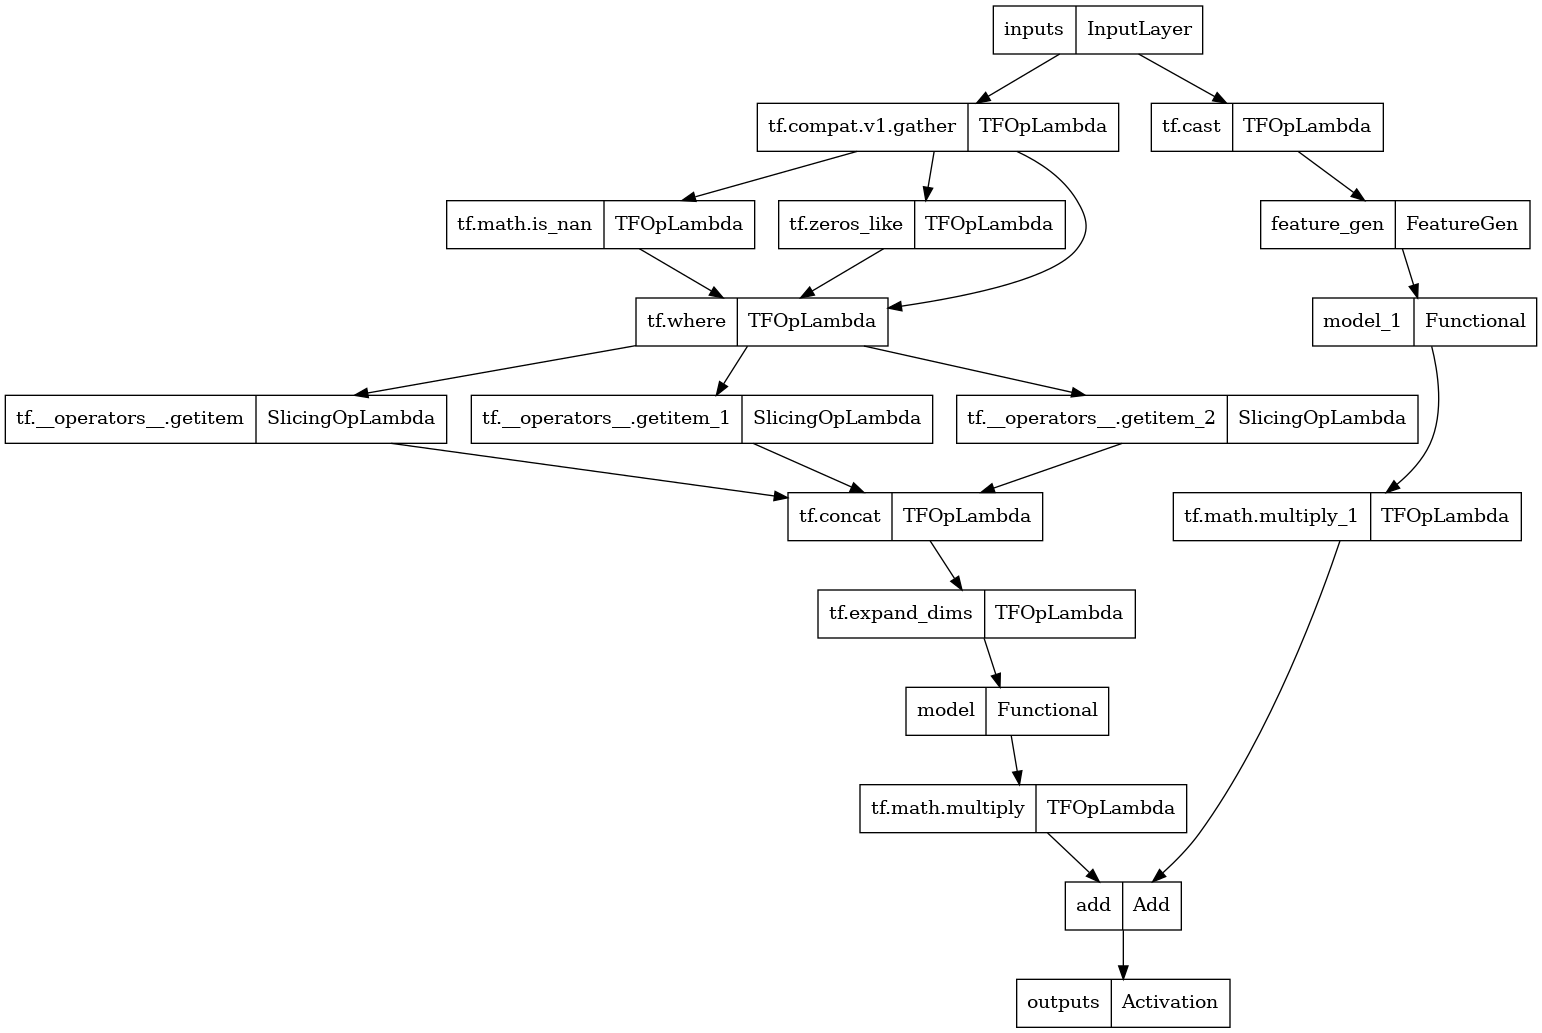

In [9]:
inference_model = get_inference_model(ltsm_model,asl_model)
tf.keras.utils.plot_model(inference_model)

In [10]:
inference_model.summary(expand_nested=True)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputs (InputLayer)            [(None, 543, 3)]     0           []                               
                                                                                                  
 tf.compat.v1.gather (TFOpLambd  (None, 88, 3)       0           ['inputs[0][0]']                 
 a)                                                                                               
                                                                                                  
 tf.math.is_nan (TFOpLambda)    (None, 88, 3)        0           ['tf.compat.v1.gather[0][0]']    
                                                                                                  
 tf.zeros_like (TFOpLambda)     (None, 88, 3)        0           ['tf.compat.v1.gather[0][0]']

### Convert model

In [11]:
converter = tf.lite.TFLiteConverter.from_keras_model(inference_model)
tflite_model = converter.convert()
model_path = "model.tflite"

with open(model_path, 'wb') as f:
    f.write(tflite_model)
!zip submission.zip $model_path

  adding: model.tflite (deflated 7%)
